In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from state_of_the_artefact.RVAE_ import RecurrentVariationalAutoEncoder
from state_of_the_artefact.representation import create_ctable, generate_midi_data
from state_of_the_artefact.utilities import reverse_sequences, interpolate

In [43]:
characters = [str(c) for c in range(24, 36)]
# encode, decode, vectorize = create_ctable(characters)
# print(len(characters))
# data = vectorize(generate_midi_data(1500 * BATCH_SIZE, TIMESTEPS, midi_range=MIDI_RANGE))
x = np.load('/Users/max/Dropbox/_repositories/state-of-the-artefact/data/seeds/seed_0.npy')
x.shape

(48000, 10, 12)

In [44]:
split_at = len(x) - len(x) // 10
x_train, y_train = reverse_sequences(x[:split_at]), x[:split_at]
x_val, y_val = reverse_sequences(x[split_at:]), x[split_at:]

In [63]:
cs = RecurrentVariationalAutoEncoder(10, len(characters), 128, 32)
cs.compile(optimizer='adam', loss="categorical_crossentropy")

In [64]:
cs.encoder.summary()
cs.decoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 10, 12)]     0                                            
__________________________________________________________________________________________________
lstm_36 (LSTM)                  (None, 10, 128)      72192       input_19[0][0]                   
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 32)           20608       lstm_36[0][0]                    
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 32)           20608       lstm_36[0][0]                    
____________________________________________________________________________________________

In [65]:
hist = cs.fit(x_train, y_train, epochs=25, batch_size=32)
# cs.load_weights("/Users/max/Dropbox/_repositories/state-of-the-artefact/data/models/agent_0_0.h5")

Epoch 1/25
 520/1350 [==========>...................] - ETA: 10s - loss: 2.4125 - kl_loss: 0.0977

KeyboardInterrupt: 

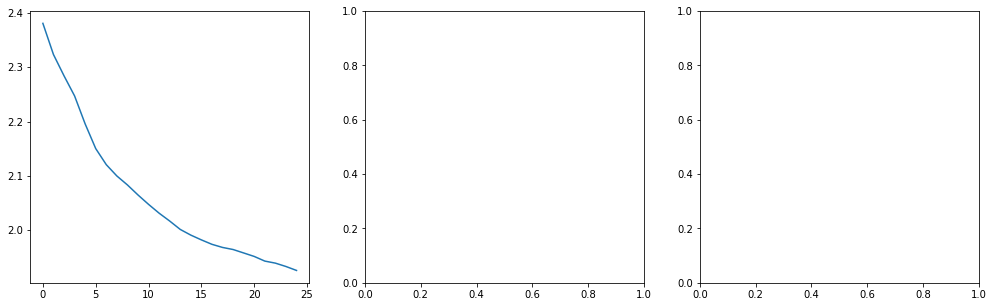

In [57]:
df = pd.DataFrame(hist.history)

fig, axs = plt.subplots(1, 3, figsize=(17, 5))
df['loss'].plot(ax=axs[0])
# df['reconstruction_loss'].plot(ax=axs[1])
# df['kl_loss'].plot(ax=axs[2])

In [48]:
cs.evaluate(x_val, y_val)

150/150 [==============================] - 1s 5ms/step - loss: 1.9294


1.9293973445892334

In [52]:
_, _, z = cs.encode(x_train)
reconstructions = cs.decode(z).numpy()
# print(reconstructions.shape)
# print(np.sum(reconstructions[0][0]))

# print(np.argmax(reconstructions[0], axis=1))
# print(np.argmax(y_train[0], axis=1))

correct = 0
for original, reconstruction in zip(y_train, reconstructions):
    a = np.argmax(original, axis=1)
    b = np.argmax(reconstruction, axis=1)
    print(a, b)
    if np.array_equiv(a, b):
        correct += 1
       
print(f"~{correct} of {len(z)} reconstructed. Accuracy is {correct / len(z)}")

  3  3  3  3]
[ 9  0 11  0  5  4  2  2  9 11] [ 2  0 11  5  4 11  9  9  9  9]
[ 1  1  5  7  8 10  3  2  3  5] [ 1  5 10  8  2  2  3  3  3  3]
[ 9  1 11  6  2  9  1  1  7  4] [11  1 11  6  1  9  9  9  1  1]
[ 0  2  9  7  1 10  0 10  4 11] [ 2  0  9  9 10 10  1  1  1  1]
[ 4  9  0  3  9 11  4  6  0  4] [3 4 5 3 9 4 4 4 4 4]
[10  0  9  3  5  1  1 10  3 11] [ 3  0  4  8  3  3 11 11 11 11]
[10  5  9  8  4  6 11 11  9  1] [11  5  9  8  4  6  6  6  4  4]
[ 7 11 10  1  9 10  6  6  8  2] [ 7  2 10  2  9  9  8  8  8  8]
[0 3 0 5 9 9 3 5 6 8] [0 3 3 5 6 6 8 8 8 8]
[10  4  9  4  7  7  1 11  4  3] [4 4 4 4 4 7 1 3 3 3]
[ 0  9  1  3  0 10  2  5  2  4] [4 9 1 3 0 2 4 4 4 4]
[ 2  4  5  3 10 11  5 10 11  0] [ 3  4  5  3  8  5 11 11 11 11]
[ 8  5  1  6 10  8  9  8  9 11] [ 8  5  1 10  3  8 11 11 11 11]
[ 0  8  6 10  7 10 10  1  7  6] [ 0  8  6 10 11  7  1  1  1  1]
[ 3  5  8  9  2  5 11 11  1  9] [3 5 8 4 5 2 2 2 2 2]
[0 7 9 6 9 7 3 7 4 1] [0 2 9 6 6 3 6 4 4 4]
[ 8  4  0  0 11  9  9  5  8  6] [7 4 0 0 9

In [55]:
budget = 200

# data = generate_midi_data(5, 16)
new_y = y_val[:10]
new_x = x_val[:10]

missclassifieds = 1
while missclassifieds > 0 and budget > 0:
    missclassifieds = 0
    history = cs.fit(new_x, new_y, epochs=1, verbose=0, batch_size=5)
    _, _, z = cs.encode(new_x)
    reconstructions = cs.decode(z).numpy()

    for original, reconstruction in zip(new_y, reconstructions):
        if not np.array_equiv(decode(original), decode(reconstruction)):
            missclassifieds += 1

    budget -= 1

print(missclassifieds, budget)

0 107


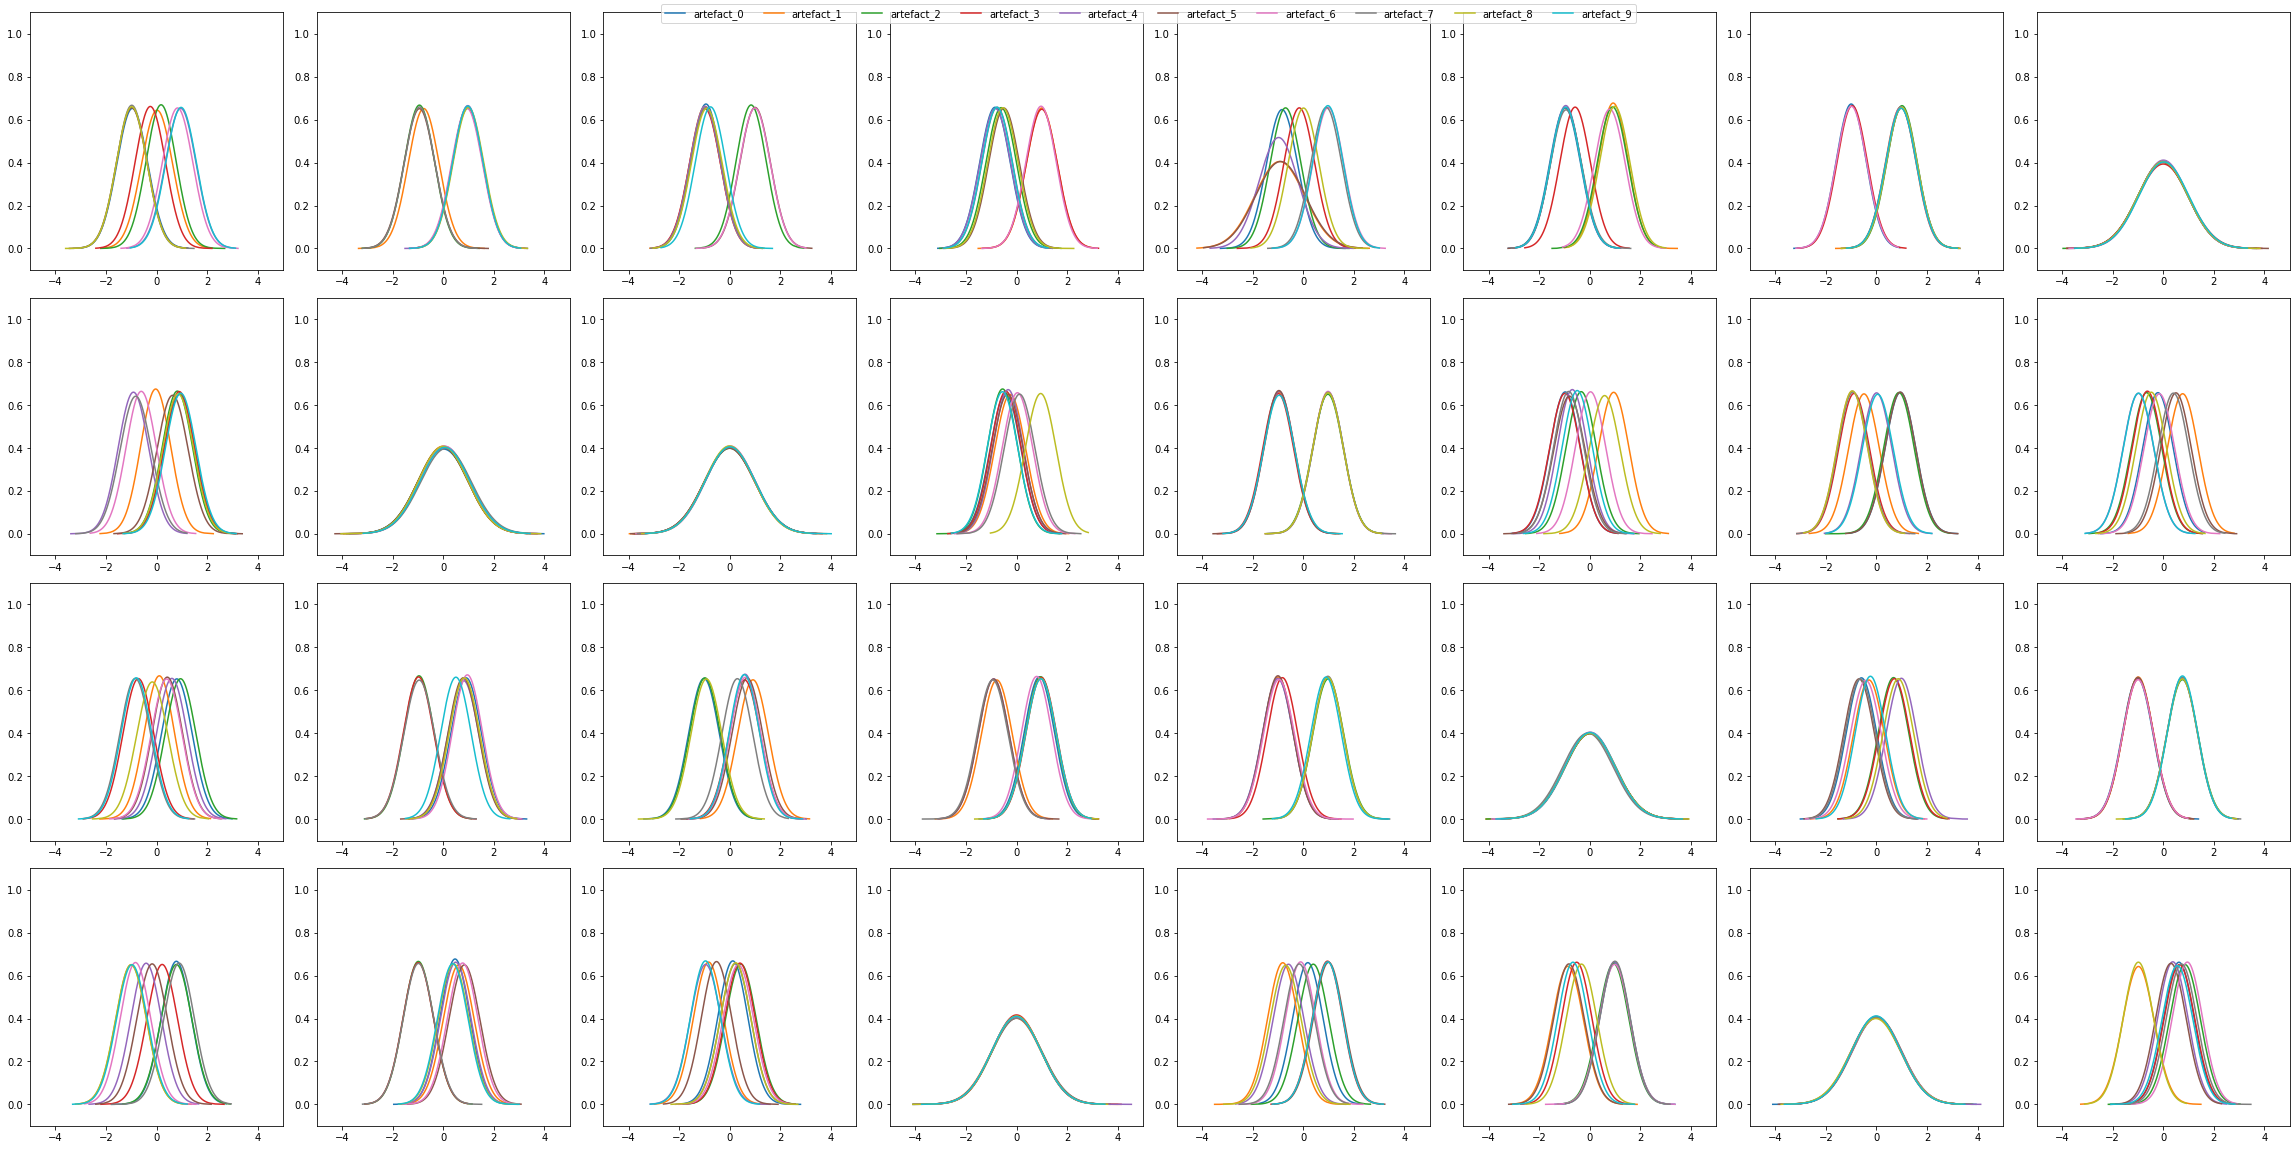

In [56]:
from scipy.stats import norm

selected_x = new_x
z_mean, z_logvar, z = cs.encode(selected_x)

fig, axs = plt.subplots(4, 8, figsize=(4 * 8, 4 * 4))
labels = [f"artefact_{i}" for i in range(0, len(selected_x))]

for i, ax in enumerate(axs.flatten()):

    for j in range(0, len(selected_x)):
        std = np.exp(0.5 * z_logvar[j][i]) # make the plots a bit saner
        h = sorted(np.random.normal(z_mean[j][i], std, 5000))
        pdf = norm.pdf(h, np.mean(h), np.std(h))
        ax.plot(h, pdf, label=labels[j])   
    
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(-5, 5)

fig.legend(loc="upper center", labels=labels, ncol=len(new_x))
plt.tight_layout()
plt.show()

In [75]:
a = new_y[3]
b = new_y[4]

z_a = z[3]
z_b = z[4]

interpolated_z = interpolate(z_a, z_b, 10)

print(decode(a))
print('-' * 45 + ' FROM ' + '-' * 45)

i_artefacts = cs.decode(interpolated_z).numpy()

for i_a in i_artefacts:
    print(decode(i_a))

print('-' * 46 + ' TO ' + '-' * 46)
print(decode(b))

['27', '33', '25', '24', '27', '25', '28', '32', '26', '35', '30', '27', '30', '25', '33', '34']
--------------------------------------------- FROM ---------------------------------------------
['27', '33', '25', '24', '27', '25', '28', '32', '26', '35', '30', '27', '30', '25', '33', '34']
['27', '33', '25', '24', '27', '25', '28', '32', '26', '35', '30', '27', '30', '25', '33', '34']
['27', '33', '25', '27', '27', '25', '32', '32', '26', '26', '30', '27', '30', '25', '33', '34']
['27', '33', '33', '27', '27', '25', '32', '26', '26', '24', '30', '27', '30', '25', '33', '34']
['29', '33', '33', '27', '25', '32', '32', '26', '26', '24', '24', '27', '35', '33', '28', '30']
['29', '33', '33', '27', '30', '32', '27', '26', '26', '24', '24', '29', '35', '28', '28', '28']
['29', '34', '33', '27', '30', '32', '27', '26', '26', '24', '31', '29', '35', '29', '28', '28']
['29', '34', '33', '27', '30', '32', '27', '26', '33', '24', '31', '29', '35', '29', '28', '28']
['29', '34', '33', '27', '30',